In [1]:
!pip install torchtext==0.6.0
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 6.1 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.1+cpu
    Uninstalling torchtext-0.15.1+cpu:
      Successfully uninstalled torchtext-0.15.1+cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 68.4 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
import string
import time
from torchtext import vocab
from torchtext.vocab import GloVe

import pandas as pd
import numpy as np
from torchtext import data
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import torch.optim as optim
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay  # new version of plot_confusion_matrix
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

In [3]:
train_path = "/kaggle/input/fast-using-lstm-model-steps/train.csv"
test_path = "/kaggle/input/fast-using-lstm-model-steps/test.csv"
model_path = '/kaggle/input/fast-using-lstm-model-steps/model.pt'
tfidf_20_words_path = "/kaggle/input/tfidf-words/import_words_20.csv"

In [4]:
df_train = pd.read_csv(train_path)
df_train_text = df_train["text"]
df_train_author_num = df_train["Author_num"]

df_test = pd.read_csv(test_path)
df_test_text = df_test["text"]
df_test_author_num = df_test["Author_num"]

In [5]:
# The first time you run this will download a ~823MB file
# glove = torchtext.vocab.GloVe(name="6B", # trained on Wikipedia 2014 corpus
#                               dim=100)

TEXT = data.Field(sequential=True, tokenize="spacy", tokenizer_language="en_core_web_sm", lower=True, include_lengths=True) # new tokenizer_language to fit new model
SCORE = data.Field(sequential=False, use_vocab=False)
datafields = [("text", TEXT), ("Author_num", SCORE)]

train= data.TabularDataset(
    path=train_path,
    format='csv',fields=datafields,skip_header = True)
val = data.TabularDataset(
    path=test_path,
    format='csv',fields=datafields,skip_header = True)


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # choose device according to hardware support
print(torch.cuda.is_available())

False


In [24]:
import pandas as pd
tfidf_20_df = pd.read_csv("/kaggle/input/tfidf-words/import_words_20.csv")

for i in range(len(tfidf_20_df)):
    print(i,tfidf_20_df["word"][i], tfidf_20_df["score"][i])

tfidf_20 = tfidf_20_df["word"]
tfidf_20 = list(tfidf_20.reset_index(drop=True))
# tfidf_20 = tfidf_20[:40]
print(tfidf_20)

0 medeva 14.018808527627751
1 marimastat 13.558038582490816
2 peptide 13.305562403064329
3 courtaulds 13.035660702596823
4 refsum 11.307200811129588
5 zantac 10.846430865992652
6 bogie 10.034140894147672
7 enviromed 9.380621471794626
8 migraine 9.380621471794626
9 milumil 9.380621471794626
10 antibodies 9.380621471794626
11 rothwell 9.380621471794626
12 tencel 9.007765855748614
13 gastric 8.595593094631425
14 marimastats 8.595593094631425
15 spall 8.595593094631425
16 rprs 8.595593094631425
17 zwanziger 8.134823149494489
18 ici 8.134823149494489
19 antibody 8.134823149494489
20 medevas 8.134823149494489
21 cortecs 8.134823149494489
22 rediker 7.612445269600498
23 ovarian 7.009404263813876
24 pancreatic 7.009404263813876
25 erling 7.009404263813876
26 chiroscience 7.009404263813876
27 therapeutic 7.009404263813876
28 padfield 7.009404263813876
29 mccullagh 7.009404263813876
30 tioxide 7.009404263813876
31 protease 7.009404263813876
32 viscose 7.009404263813876
33 aft 7.009404263813876
3

**依照GloVe換字**

In [8]:
TEXT.build_vocab(train, val, min_freq = 3, vectors=GloVe(name='6B', dim=100))
glove = TEXT.vocab

.vector_cache/glove.6B.zip: 862MB [02:41, 5.35MB/s]                               
100%|█████████▉| 399999/400000 [00:23<00:00, 17324.42it/s]


In [10]:

def get_similar_word_glove(text="", important_word = [], important_len = 50, top_n = 10):
    def get_word(word):
        return glove.vectors[glove.stoi[word]]

    def closest(vec, n=10):
        all_dists = [(w, torch.dist(vec, get_word(w))) for w in glove.itos]
        sorted_dists = sorted(all_dists, key=lambda t: t[1])
        return [sorted_dists[i][0] for i in range(1,n+1)]

    similar_word = {}
    for i in range(important_len):
        similar_word[important_word[i]] = closest(get_word(important_word[i]), top_n)
        
    return similar_word
    

In [11]:
start_time = time.time()
similar_word_glove = get_similar_word_glove("", tfidf_20, len(tfidf_20), 30)
print("time: ", time.time() - start_time)

KeyboardInterrupt: 

In [10]:
print(similar_word_glove)

{'medeva': ['unigate', 'chiroscience', 'celltech', 'stakis', 'mepc', 'firstbus', 'lucasvarity', 'm.a.i.d', 'hammerson', 'lasmo', 'cgip', 'flextech', 'milupa', 'gkn', 'ventritex', 'misys', 'racal', 'zoladex', 'minorco', 'commscope', 'greenalls', 'nutricia', 'btr', 'microcom', 'dalgety', 'comapny', '<unk>', '<pad>', '\n', ' \n'], 'marimastat': ['zestril', 'zoladex', 'vml', 'comapny', 'druzhinin', 'demutualisation', 'herst', 'mc4', 'backweb', 'sames', 'novellist', 'imigran', 'yogen', 'sytem', 'forcasts', 'atai', 'bcms', 'zomig', 'katies', 'camptosar', 'attrocities', 'padfield', 'meisels', 'iguide', 'gulda', 'servies', 'xalatan', 'gaint', 'pivovar', '+3.00'], 'peptide': ['calcitonin', 'precursor', 'antigens', 'prp', 'bind', 'bedoya', 'fibres', 'alternatively', 'encode', 'orejuela', 'derivative', 'residue', 'sequence', 'ogawa', 'transporters', '<unk>', '<pad>', '\n', ' \n', 'at&amp;t', ' ', '    ', '   ', '\n ', 'scotam', '  ', 'mgam', '\t', '..', 'c&amp;w'], 'courtaulds': ['medeva', 'cellt

In [13]:
import csv
with open("GloVe_wrong.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["word", "similar1", "similar2", "similar3", "similar4", "similar5", "similar6", "similar7", "similar8", "similar9", "similar10", "similar11", "similar12", "similar13", "similar14", "similar15", "similar16","similar17", "similar18", "similar19", "similar20", "similar21", "similar22", "similar23", "similar24", "similar25", "similar26", "similar27", "similar28", "similar29", "similar30"])
    for i in range(len(similar_word_glove)):
        writer.writerow([tfidf_20[i]]+similar_word_glove[tfidf_20[i]])


**依詞性換詞**

In [25]:
stop_words = set(stopwords.words('english'))
tfidf_pos = {}

for i in range(len(tfidf_20)):
    txt = tfidf_20[i]

    # sent_tokenize is one of instances of 
    # PunktSentenceTokenizer from the nltk.tokenize.punkt module

    tokenized = sent_tokenize(txt)
    # Word tokenizers is used to find the words 
    # and punctuation in a string
    wordsList = nltk.word_tokenize(tokenized[0])

    # removing stop words from wordList
    wordsList = [w for w in wordsList if not w in stop_words] 

    #  Using a Tagger. Which is part-of-speech 
    # tagger or POS-tagger. 
    tagged = nltk.pos_tag(wordsList)

    if(tagged[0][1] in tfidf_pos):
        tfidf_pos[tagged[0][1]].append(tagged[0][0])
    else:
        tfidf_pos[tagged[0][1]] = [tagged[0][0]]

# print(type(tfidf_pos))
# print(tfidf_pos.keys())
l = 0
for key in tfidf_pos.keys():
    tfidf_pos[key] = tfidf_pos[key][:int(0.7*len(tfidf_pos[key])+1)]
    if(len(tfidf_pos[key]) == 0):
        del tfidf_pos[key]
    l += len(tfidf_pos[key])
     
print(tfidf_pos)
print(l)


{'NN': ['medeva', 'marimastat', 'peptide', 'refsum', 'zantac', 'bogie', 'migraine', 'milumil', 'rothwell', 'tencel', 'gastric', 'spall', 'rprs', 'zwanziger', 'ici', 'antibody', 'medevas', 'cortecs', 'rediker', 'chiroscience', 'padfield', 'mccullagh', 'tioxide', 'protease', 'viscose', 'aft', 'rentokil', 'leng', 'selfcare', 'viyella', 'nolvadex', 'zenecas', 'retrovir', 'rosenkranz', 'accolate', 'woolf', 'rhie', 'chiswell', 'dermagraft', 'laporte', 'howden', 'wieczorek', 'hepagene', 'rizla', 'novopharm', 'biggestselling'], 'NNS': ['courtaulds', 'antibodies', 'marimastats', 'enviromeds', 'howdens', 'peptides', 'colloids'], 'VBN': ['enviromed', 'oxfordbased'], 'JJ': ['ovarian', 'pancreatic', 'therapeutic'], 'VBG': ['erling']}
59


In [26]:
def weighted_random_choice(lst):
    total_weight = sum(range(1, len(lst) + 1))
    probabilities = [len(lst)+1-i / total_weight for i in range(1, len(lst) + 1)]

    chosen_element = random.choices(lst, probabilities, k=1)[0]
    return chosen_element


In [27]:
def change_tfidf(text, change_rate=0.8):
    split_text = [word.strip(string.punctuation) for word in text.split()]
    change_text = split_text[:]
    stop_words = set(stopwords.words('english'))
    can_change = 0
    change = 0
    
    total_words = 0
    total_can_change = 0
    total_change = 0
    
    for i in range(len(split_text)):
        tokenized = sent_tokenize(split_text[i])
#         print(split_text[i],tokenized)
        if(tokenized == []):
            continue
        wordsList = nltk.word_tokenize(tokenized[0])

        # removing stop words from wordList
        wordsList = [w for w in wordsList if not w in stop_words] 

        #  Using a Tagger. Which is part-of-speech 
        # tagger or POS-tagger. 
        tagged = nltk.pos_tag(wordsList)
        if(tagged == []):
            continue

        pos = tagged[0][1]

        if(pos in tfidf_pos):
            can_change += 1
            if(random.random() < change_rate):
                replace_word_list = tfidf_pos[pos]
                replace_word = weighted_random_choice(replace_word_list)
                change_text[i] = replace_word
                change += 1
    
#         total_words += len(split_text)
#         total_can_change += can_change
#         total_change += change
    
#     print("len:",len(split_text))
#     print("can_change:", can_change)
#     print("change:",change)

    change_text = " ".join(change_text)
    return (change_text, len(split_text), can_change, change)
            

In [28]:
start_time = time.time()
text_after_change = []
total_text_num = 0
total_can_change = 0
total_change = 0
for i in range(len(df_test_text)):
#     print(df_test_text[i])
    tmp_text, tmp_text_num, tmp_can_change, tmp_change = change_tfidf(df_test_text[i],1)
#     print(change_tfidf(df_test_text[i],0.9))
#     print(tmp_text)
    text_after_change.append(tmp_text)
    total_text_num += tmp_text_num
    total_can_change += tmp_can_change
    total_change += tmp_change
print("time:",time.time()-start_time)
print("avg text num:",total_text_num/len(df_test_text))
print("avg can change:",total_can_change/len(df_test_text))
print("avg change:",total_change/len(df_test_text))


time: 124.5064868927002
avg text num: 499.886
avg can change: 223.224
avg change: 223.224


**Stanford Model**

In [29]:
class AuthorClassifier(nn.Module):

    def __init__(self, mode, output_size, hidden_size, vocab_size, embedding_length, word_embeddings):
        super(AuthorClassifier, self).__init__()

        if mode not in ['rnn', 'lstm', 'gru', 'bilstm']:
            raise ValueError("Choose a mode from - rnn / lstm / gru / bilstm")

        self.mode = mode
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.embedding_length = embedding_length
        self.embedding = nn.Embedding(self.vocab_size,self.embedding_length)
        self.embedding.weight = nn.Parameter(word_embeddings,requires_grad = False)

        if self.mode == 'rnn':
            self.network = nn.RNN(self.embedding_length,self.hidden_size)
        elif self.mode == 'lstm':
            self.network = nn.LSTM(self.embedding_length,self.hidden_size)
        elif self.mode == 'gru':
            self.network = nn.GRU(self.embedding_length,self.hidden_size)
        elif self.mode == 'bilstm':
            self.network = nn.LSTM(self.embedding_length,self.hidden_size,bidirectional = True)


        self.fclayer = nn.Linear(self.hidden_size,self.output_size)


    def forward(self, text, text_lengths):
        text_embeddings = self.embedding(text)
        pack_sequence = nn.utils.rnn.pack_padded_sequence(text_embeddings,text_lengths.cpu()) # lengths.cpu() for matching new input format

        if self.mode in ('lstm', 'bilstm'):
            _, (hidden, cell) = self.network(pack_sequence)
            if self.mode == 'bilstm':
                hidden = hidden[0,:,:] + hidden[1,:,:]
        else:
            _, hidden = self.network(pack_sequence)
        
        hidden = hidden.squeeze(0)
        pred = self.fclayer(hidden)
        return pred

def evaluate_classifier(model, dataset_iterator, loss_function, recurrent = True):
    model.eval()

    correct = 0
    total = 0
    total_loss = 0
    overall_pred = []
    overall_label = []
    accuracy_test = []
    loss_test = []
    f1_step = 0
    f1 = 0

    for batch in dataset_iterator:
        comment, comment_lengths = batch.text
        labels = batch.Author_num   # tag of author number
        
        # ---------修改部分---------#
        # output是dense層的輸出，但還未經過最後一層activation層(softmax)
        output = model(comment, comment_lengths).squeeze(0)
        
        # 所以這裡額外新增一個softmax層計算，結果就會是對50位作者的機率，機率和為1。
        softmax = F.softmax(output, dim=1)
        
        # 這裡的data[0]指的是該batch中的第一筆資料
        print(softmax.data[0])
        
        # 這裡找出機率最大的，代表模型判斷結果
        print("result:")
        print(torch.max(output.data,1).indices)
        
        # prediction will be the values in each row
        # they represent the possibility(weight) of an article which belongs to jth author(in jth row)
        # ---------修改部分---------#

        loss = loss_function(output, labels.long()) # .long means .to(torch.int64)
        pred = torch.max(output.data,1).indices
        correct += (torch.sum(pred == labels)).item()
        total += len(labels)
        total_loss += loss.item()
        ap = pred.cpu()
        a = np.asarray(ap)
        labels = labels.cpu()
        b = np.asarray(labels)
        f1_step += 1
        overall_pred.append(a)
        overall_label.append(b)

    overall_p = [val for sublist in overall_pred for val in sublist]
    overall_l = [val for sublist in overall_label for val in sublist]
    f1ss = sklearn.metrics.f1_score(overall_l,overall_p,average= 'macro')
    accuracy_test.append(correct/total)
    loss_test.append(total_loss/total)
    print("Validation statistics: Acc: %s Loss: %s"%(correct/total, total_loss/total),'F1 Score:',f1ss)
    return overall_pred,overall_label,accuracy_test,f1ss,loss_test

In [ ]:
class DataFrameDataset(data.Dataset):

    def __init__(self, df, text_field, label_field, is_test=False, **kwargs):
        fields = [('text', text_field), ('Author_num', label_field)]
        examples = []
        for i, row in df.iterrows():
            label = row.Author_num if not is_test else None
            text = row.text
            examples.append(data.Example.fromlist([text, label], fields))

        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex):
        return len(ex.text)

    @classmethod
    def splits(cls, text_field, label_field, train_df, val_df=None, test_df=None, **kwargs):
        train_data, val_data, test_data = (None, None, None)

        if train_df is not None:
            train_data = cls(train_df.copy(), text_field, label_field, **kwargs)
        if val_df is not None:
            val_data = cls(val_df.copy(), text_field, label_field, **kwargs)
        if test_df is not None:
            test_data = cls(test_df.copy(), text_field, label_field, True, **kwargs)

        return tuple(d for d in (train_data, val_data, test_data) if d is not None)
        
train_ds, val_ds, test_ds = DataFrameDataset.splits(
  text_field=TEXT_FIELD, label_field=LABEL_FIELD, train_df=train_df, val_df=val_df, test_df=test_df)

In [30]:
if(torch.cuda.is_available()):
    model = torch.load(model_path)
else:
    model = torch.load(model_path, map_location=torch.device('cpu'))
loss_function = nn.CrossEntropyLoss()

In [31]:
#方法二
start_time = time.time()
#----------你需要修改-----------#
my_article_df = pd.DataFrame({
    'text' : [t for t in text_after_change],
    'Author_num' : [a for a in df_test_author_num]
})
#----------你需要修改-----------#

my_article_df.to_csv('tmp.csv', index=False)

# 轉換成Dataset
dataset = data.TabularDataset(
    path='tmp.csv',
    format='csv',fields=datafields,skip_header = True)

articles_word_grad_test_Iterator = data.BucketIterator(
    dataset,
    batch_size = 2,
    sort_key = lambda x: len(x.text),
    sort_within_batch = True,
    repeat=False,
    shuffle=True,
    device = device)
_ = evaluate_classifier(model, articles_word_grad_test_Iterator, loss_function)
# print("oooooo:",_)
print("time:",time.time()-start_time)

tensor([1.6657e-08, 3.7834e-05, 2.2798e-06, 6.4083e-06, 4.6201e-05, 2.2409e-07,
        2.5940e-07, 8.9862e-05, 1.4500e-04, 8.4768e-06, 3.9116e-08, 1.7224e-06,
        7.3478e-07, 7.2432e-05, 3.5170e-05, 3.8646e-05, 3.4406e-06, 3.6510e-06,
        1.0198e-05, 6.6428e-04, 6.9659e-05, 1.1271e-04, 1.6553e-07, 3.5269e-04,
        5.1282e-04, 3.8840e-05, 2.2568e-05, 1.5305e-04, 2.3928e-04, 3.0982e-02,
        5.2246e-05, 9.4285e-05, 9.6396e-01, 8.6440e-07, 4.0037e-06, 1.7765e-05,
        2.2527e-04, 3.5939e-07, 1.5507e-04, 6.6765e-07, 8.8391e-09, 1.2874e-04,
        4.7431e-06, 1.1430e-04, 2.0187e-06, 1.7602e-06, 3.0170e-04, 1.2658e-03,
        6.1434e-06, 1.7711e-05])
result:
tensor([32, 19])
tensor([1.6992e-04, 3.7446e-03, 1.2927e-03, 9.1456e-04, 3.8217e-03, 9.7584e-05,
        4.0773e-03, 1.9412e-03, 4.0828e-03, 1.8422e-03, 8.2743e-05, 4.4841e-04,
        4.3348e-02, 2.8174e-03, 2.6810e-04, 2.2840e-02, 1.7426e-04, 7.6861e-05,
        2.1709e-03, 2.0897e-02, 5.1391e-03, 3.5720e-04, 4.2683

In [ ]:
def model_evaluate(my_df):
    my_ds = DataFrameDataset(my_df,TEXT,SCORE)
    
    articles_word_grad_test_Iterator = data.BucketIterator(
    my_ds,
    batch_size = 2,
    sort_key = lambda x: len(x.text),
    sort_within_batch = True,
    repeat=False,
    shuffle=True,
    device = device)
    evaluation = evaluate_classifier(model, articles_word_grad_test_Iterator, loss_function)
    return evaluation
    

tensor([4.9872e-07, 5.1537e-04, 4.6232e-03, 1.1612e-04, 3.1483e-04, 3.9167e-07,
        8.2790e-04, 7.4559e-08, 3.6761e-03, 5.9766e-07, 4.4054e-06, 3.4013e-08,
        2.0640e-04, 5.6115e-05, 3.1414e-05, 3.9877e-03, 1.8964e-07, 6.1990e-05,
        1.1760e-04, 9.4045e-01, 1.8513e-03, 7.3499e-05, 7.4578e-06, 5.2705e-05,
        9.2508e-07, 6.0979e-06, 1.9481e-05, 1.4337e-05, 3.5168e-02, 5.1630e-06,
        3.2744e-05, 4.8058e-06, 9.1440e-07, 3.4172e-07, 7.9989e-04, 1.7324e-06,
        1.6272e-06, 5.5711e-06, 6.4970e-06, 2.3638e-05, 5.0849e-06, 1.2391e-05,
        5.0050e-07, 8.0277e-06, 6.5375e-06, 6.6754e-03, 1.8322e-06, 2.0720e-04,
        1.5715e-05, 1.1383e-06])
result:
tensor([19, 47])
tensor([8.7964e-07, 6.0419e-03, 6.2974e-02, 1.8218e-05, 1.0187e-03, 6.7984e-05,
        1.0859e-03, 4.6260e-07, 2.3967e-01, 1.6344e-04, 1.1708e-05, 1.3915e-04,
        6.8070e-03, 5.0549e-04, 6.1652e-04, 3.6729e-04, 6.6485e-04, 3.7100e-04,
        1.3200e-03, 6.1927e-01, 1.8251e-05, 6.4560e-05, 1.1792

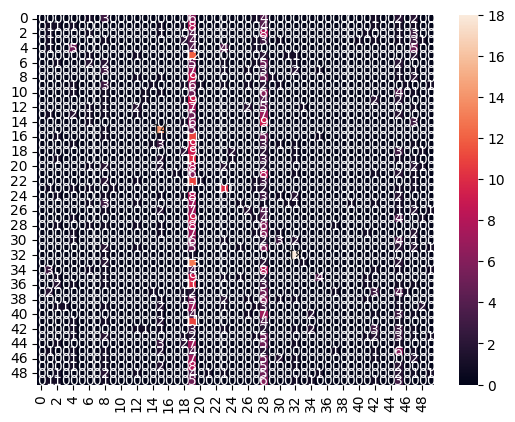

In [32]:
start_time = time.time()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
log_dir = 'runs/lstm1'
final_acc_train_lstm  = []
final_loss_train_lstm = []
final_loss_test_lstm = []
final_acc_test_lstm = []
final_f1score_train_lstm = []
final_f1score_test_lstm = []


overall_pred,overall_label,accs_test,f1ss,loss_test = evaluate_classifier(model, articles_word_grad_test_Iterator, loss_function)
final_acc_test_lstm.append(accs_test[0])
final_f1score_test_lstm.append(f1ss)
final_loss_test_lstm.append(loss_test[0])

cf = np.zeros((50,50))

overall_pred = [val for sublist in overall_pred for val in sublist]
print("overall_pred:",overall_pred)

overall_label = [val for sublist in overall_label for val in sublist]
print("overall_label:",overall_label)

ziplist = list(zip(overall_label,overall_pred))
for coordinate in ziplist:
    cf[coordinate]+=1
ax = sns.heatmap(cf,annot=True)
print("time:",time.time() - start_time)

count_20: 310
rate_20: 0.31


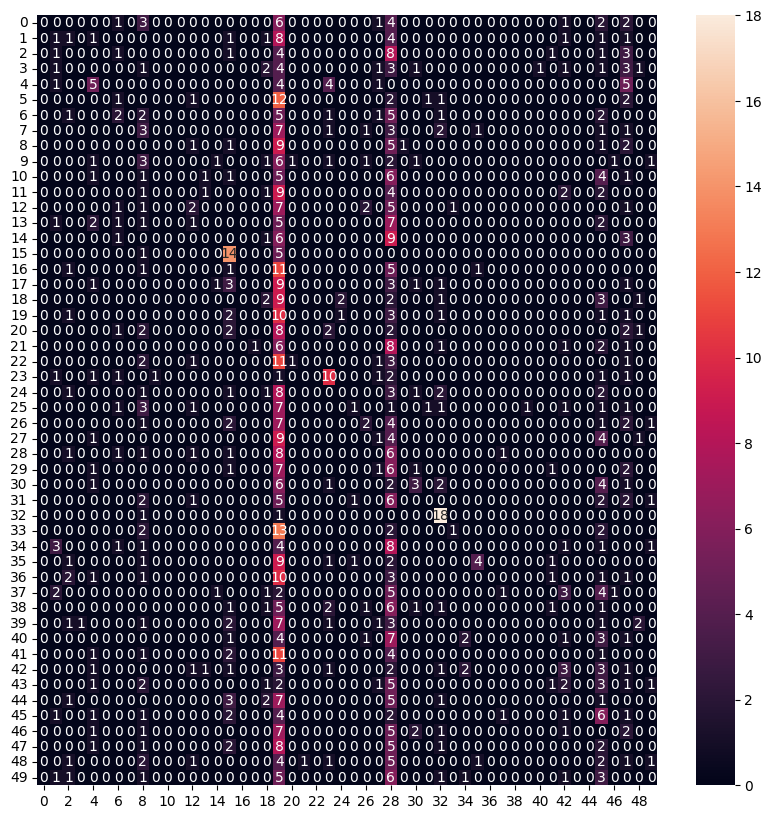

In [33]:
# sns.set (rc = {'figure.figsize':(7, 7)})
plt.figure(figsize=(10, 10))
ax = sns.heatmap(cf,annot=True)

count_20 = overall_pred.count(19)
count_20 -= overall_label.count(19)
rate_20 = count_20/len(overall_pred)
print("count_20:",count_20)
print("rate_20:",rate_20)


In [34]:
import tensorflow_hub as hub
import tensorflow as tf

similarity_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

def similarity_cal(sentence1, sentence2):
    # create sentence embedding
    embedding1 = similarity_model([sentence1])[0]
    embedding2 = similarity_model([sentence2])[0]

    # calculate cosine simularity
    cosine_similarity = np.dot(embedding1, embedding2) / (np.linalg.norm(embedding1) * np.linalg.norm(embedding2))
    # print("相似度:", cosine_similarity)

    return cosine_similarity

In [35]:
total_similarity = 0
for i in range(len(df_test_text)):
    total_similarity += similarity_cal(df_test_text[i], text_after_change[i])
print("avg similarity: ", total_similarity/len(df_test_text))

avg similarity:  0.3741569392979145


**Start GA**

In [76]:
def generate_initial(original, author_num):
    initial = []
    for i in range(50):
        tmp_text1, a1, b1, c1 = change_tfidf(original,0.9)
        tmp_text2, a2, b2, c2 = change_tfidf(original,0.9)
        my_article_df = pd.DataFrame({
            'text' : [tmp_text1, tmp_text2],
            'Author_num' : [author_num, author_num]
        })

        my_article_df.to_csv('tmp.csv', index=False)

        # 轉換成Dataset
        dataset = data.TabularDataset(
            path='tmp.csv',
            format='csv',fields=datafields,skip_header = True)

        articles_word_grad_test_Iterator = data.BucketIterator(
            dataset,
            batch_size = 2,
            sort_key = lambda x: len(x.text),
            sort_within_batch = True,
            repeat=False,
            shuffle=True,
            device = device)

        evaluation = evaluate_classifier(model, articles_word_grad_test_Iterator, loss_function)
        result,a3,b3,c3,d3 = evaluation
        result = result[0]

        if(result[0] == 19):
            initial.append(tmp_text1)
        if(len(initial)) >= 5:
            return initial
        if(result[1] == 19):
            initial.append(tmp_text2)
    return initial


In [ ]:
start_time = time.time()
initial_generation = []
total_author_num = []

for i in range(len(df_test_text)):
    initial = generate_initial(df_test_text[i], df_test_author_num[i])
    if(initial != []):
        initial_generation.append()
        total_author_num.append(df_test_author_num[i])
end_time = time.time()

tensor([9.0070e-06, 1.5726e-01, 6.9653e-03, 7.7022e-04, 8.9710e-02, 1.1755e-05,
        3.5326e-02, 4.9622e-05, 1.6340e-02, 1.5256e-03, 7.2064e-05, 1.0043e-05,
        1.4455e-02, 1.4283e-03, 5.5635e-04, 2.6125e-02, 5.8965e-05, 4.8964e-04,
        3.7590e-03, 3.9894e-01, 2.3987e-02, 6.1615e-05, 1.7650e-03, 9.9334e-04,
        2.4020e-04, 3.2866e-05, 8.8762e-03, 7.9442e-04, 2.5758e-02, 1.2949e-03,
        3.7884e-03, 4.5366e-05, 3.6983e-03, 1.6736e-04, 1.0369e-05, 1.4144e-04,
        2.1829e-03, 3.8161e-05, 1.3364e-02, 1.2031e-02, 9.6404e-06, 1.2689e-03,
        2.8118e-03, 4.7303e-04, 2.5983e-03, 1.1512e-01, 3.8069e-04, 2.3347e-02,
        8.4274e-04, 1.4212e-05])
result:
tensor([19, 19])
Validation statistics: Acc: 0.0 Loss: 3.446572780609131 F1 Score: 0.0
tensor([1.9126e-05, 6.8085e-03, 5.0982e-03, 2.8033e-05, 2.9427e-03, 4.4347e-06,
        1.4543e-03, 1.3018e-04, 1.6673e-02, 2.5830e-04, 2.0684e-04, 1.7931e-04,
        1.8556e-02, 9.2001e-04, 3.6971e-04, 3.9058e-02, 1.7209e-04, 1.12

In [ ]:
print("time:",end_time - start_time)

In [ ]:
import csv
with open("test.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    t = [i for i in range(len(initial_generation))]
    writer.writerow(t)
    writer.writerow(initial_generation)
    writer.writerow(author_num)

In [2]:
# original = ""
# parents = ["For a second, he felt as if he was blind, because everything went completely black. Tomas shouted in shock, but the lights were already on again. That was not part of his plan. He had no idea what had just happened.",
#               "For a moment, she felt as if she was handsome, because everything went entirely black. Tomas yelded in shock, but the lights were already on again. That was not part of her plan. She had no idea what had just occured.",
#               "For a while, she feels as if she was blind, because anything goes completely dark. Tomas shouted at shock, but the lights are already in again. That is not part of her plan. He has one idea what had just happened.",
#               "For an second, he felt as if he is pretty, because everything go totally black. Tomas shouted on shock, but a lights were already on again. This was not part of his plan. She had no thought what has just happened."]




In [72]:
# split_parents = np.array([])
# for i in range(len(parents)):
# split_parents = np.array([[word.strip(string.punctuation) for word in parents[i].split()] for i in range(len(parents))])

In [34]:
# print(type(split_parents[0]))

<class 'numpy.ndarray'>


In [ ]:
# split_parents = np.array([np.append(split_parents[i], fitness(split_parents[i], "")) for i in range(len(split_parents))])
# print(split_parents)

In [33]:
random.seed(time.time())

In [73]:
def fitness(modification, original):
    return similarity_cal(modifacation, original)

In [77]:
def crossover(parent1, parent2, original = ""):
    parent1 = parent1[:-1]
    parent2 = parent2[:-1]
    c = np.array([parent1[i] if random.randint(0,1) == 1 else parent2[i] for i in range(len(parent1))])
    c = np.append(c, fitness(c, original))
    return c

In [78]:
# child = crossover(split_parents[0], split_parents[1], "")
# print(child)


['For' 'a' 'second' 'he' 'felt' 'as' 'if' 'she' 'was' 'blind' 'because'

 'everything' 'went' 'entirely' 'black' 'Tomas' 'yelded' 'in' 'shock'

 'but' 'the' 'lights' 'were' 'already' 'on' 'again' 'That' 'was' 'not'

 'part' 'of' 'his' 'plan' 'He' 'had' 'no' 'idea' 'what' 'had' 'just'

 '0.6179938098114072']


In [79]:

def mutation(sentence, original=""):
    sentence = sentence[:-1]
    m = np.array([sentence[i] if random.random() > 0.05 else original[i] for i in range(len(sentence))])
    m = np.append(m, fitness(m, original))
    return m

In [97]:
def selection(split_parents, top_n=5):
    column_to_sort_by = -1
    sorted_indices = np.argsort(split_parents[:, column_to_sort_by])
    sorted_arr = split_parents[sorted_indices][::-1]
    return sorted_arr[:top_n]

In [ ]:
ga_text = []

for i in range(len(initial_generation)):
    generation = initial_generation[i][:]
    origianl = df_test_text[i]
    break_flag = False
    for j in range(20):
        split_parents = np.array([[word for word in generation[i].split()] for i in range(len(generation))])
        split_parents = np.array([np.append(split_parents[i], fitness(split_parents[i], original)) for i in range(len(split_parents))])
        children = []
        
        for k in range(len(generation)):
            for l in range(k+1, len(generation)):
                child = crossover(split_parents[k], split_parents[l], original)
                child = mutation(child)
                my_article_df = pd.DataFrame({
                    'text' : [child, child],
                    'Author_num' : [df_test_author_num[i], df_test_author_num[i]]
                })
                if(similarity_cal(child, original) > (float(split_parents[k][-1]) + float(split_parents[l][-1]))/2):
                    result,a0,b0,c0,d0 = model_evaluate(my_article_df)
                    if(result[0] == 19)
                        generation.append(child)
                        
        generation = selection(generation, min(5, int(0.5 * len(generation))))
        if(len(generation) == 1):
            break_flag = True
            break
            
    if(break_flag):
        ga_text.append(" ".join(generation[0]))
    else:
        t = generation[0]
        score = -1
        for i in range(len(generation)):
            if(float(generation[i][-1]) > score):
                score = float(generation[i][-1])
                t = generation[i]
        ga_text.append(" ".join(t))    

In [ ]:
my_ga_article_df = pd.DataFrame({
    'text' : [t for t in ga_text],
    'Author_num' : [a for a in total_author_num]
})

ga_evaluation = model_evaluation(my_ga_article_df)

In [ ]:
start_time = time.time()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
log_dir = 'runs/lstm1'
final_acc_train_lstm  = []
final_loss_train_lstm = []
final_loss_test_lstm = []
final_acc_test_lstm = []
final_f1score_train_lstm = []
final_f1score_test_lstm = []


overall_pred,overall_label,accs_test,f1ss,loss_test = evaluate_classifier(model, articles_word_grad_test_Iterator, loss_function)
final_acc_test_lstm.append(accs_test[0])
final_f1score_test_lstm.append(f1ss)
final_loss_test_lstm.append(loss_test[0])

cf = np.zeros((50,50))

overall_pred = [val for sublist in overall_pred for val in sublist]
print("overall_pred:",overall_pred)

overall_label = [val for sublist in overall_label for val in sublist]
print("overall_label:",overall_label)

ziplist = list(zip(overall_label,overall_pred))
for coordinate in ziplist:
    cf[coordinate]+=1
ax = sns.heatmap(cf,annot=True)
print("time:",time.time() - start_time)

In [ ]:
ga_similarity = []
for i in range(ga_text):
    ga_similarity.append(similarity_cal(ga_text, df_test_text[total_author_num[i]]))

print("average similarity of GA text: ", sum(ga_similarity)/len(ga_similarity))
